# ISLR- Python Ch8: Lab 4- Boosting

- [Load Boston Dataset](#Load-Boston-Dataset)
- [Split Data](#Split-Data)
- [Apply Gradient Boosting](#Apply-Gradient-Boosting)
- [Partial Dependence Plot](#Partial-Dependence-Plot)
- [Compute Test MSE](#Compute-Test-MSE)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence

%matplotlib inline
plt.style.use('ggplot')

## Load Boston Dataset

In [2]:
df = pd.read_csv('../../data/Boston.csv', index_col=0)
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Split Data

In [3]:
# Get the predictors and the response values
X = df[df.columns[0:-1]].values # get all the columns except the medv
y = df['medv'].values

# The lab uses a 50/50 split. We'll do the same
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

## Apply Gradient Boosting

In [5]:
# Create a boosting object using 'least squares' obj func, with a learning rate of .001 and 5000 iterations
# each with depth of 4
booster = GradientBoostingRegressor(loss='ls', learning_rate=0.001, n_estimators=5000, max_depth=4, 
                                    random_state=0)

boost_est = booster.fit(X_train, y_train)

In [13]:
# Examine the feature importances
feature_importances = pd.Series(data=boost_est.feature_importances_, index=list(df.columns[0:-1]))
sorted_feature_importances = feature_importances.sort_values(axis=0, ascending=False)
sorted_feature_importances

lstat      0.338600
rm         0.198662
dis        0.087841
ptratio    0.081314
crim       0.071889
age        0.065210
black      0.049838
tax        0.043171
nox        0.020965
indus      0.019229
chas       0.010668
rad        0.008703
zn         0.003912
dtype: float64

## Partial Dependence Plot

One of the advantages of parametric statistical learning methods such as linear regression is that we can easily interpret the effect of a single predictor on the model by examing each covariates coeffecients. With boosted decision trees interpreting a model can be difficult. One method is to consider partial dependence plots.

A partial dependence plot examines the effect of single predictor after averaging out the effect of all other predictors. Please see https://cran.r-project.org/web/packages/datarobot/vignettes/PartialDependence.html. Briefly recall that our estimate for the response y can be written as $\hat{y}_k = F(x_{1k}, x_{2k},...x_{pk}$ where k is the number of observations and p is the covariate number. Now lets suppose that we average all the $\hat{y}_k$ except for one covariate which we leave free to vary. We can write this as $\phi_j(x) = \frac{1}{N} \sum_{k=1}^{N} F(x_{1,k}, x_{2,k},...x_{j-1,k},x, x_{j+1,k},...x_{p,k})$. This is equivalent to writing $\phi(x) = \frac{1}{N}(\hat{y}_1 + \hat{y}_2 + ... y_j(x) + .... \hat{y}_p)$. So what $\phi(x)$ represents is the effect of the jth covariate after averaging out the effects from all the other covariates. Note there is a drawback in that it will miss interaction effects. Sklearn provides the functionality we require to make a plot of $\phi(x)$.

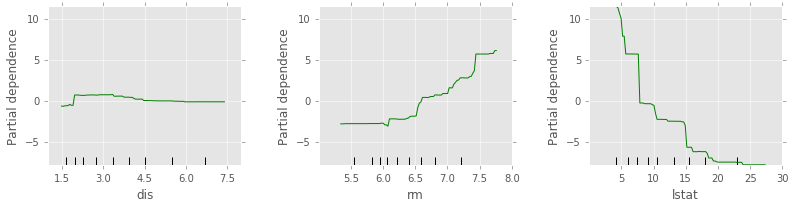

In [48]:
# Get the three feature indexes with the highest importance (lstat, rm, dis)
feature_idxs=np.argsort(feature_importances.values)[-3:]
# Create the PDP
fig, axs = plt.subplots(1,1, figsize=(12,4))
plot_partial_dependence(boost_est, X_train, features=feature_idxs, 
                                    feature_names=feature_importances.index.tolist(), ax=axs);

This plots make sense with what we know about this dataset from previous labs. Increasing number of rooms increases the medv and decreasing lstat ( a poverty measure) increases medv.

## Compute Test MSE

In [49]:
# Make predictions
y_pred = boost_est.predict(X_test)
# compute test mse
mse = np.mean((y_test-y_pred)**2)
print("Test MSE = ", mse)

Test MSE =  17.5185460028


This value is close to the value for the random forest and both techniques improve slightly over bagging.